# Part 1: Data Preparation and Exploration

In [11]:
import pandas as pd
#1.	Data Loading
df = pd.read_csv(r"C:\Users\Raiyana Reyaz\OneDrive\Desktop\data science assignments\time series\exchange_rate.csv")

df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M")

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB
None
        date  Ex_rate
0 1990-01-01   0.7855
1 1990-01-02   0.7818
2 1990-01-03   0.7867
3 1990-01-04   0.7860
4 1990-01-05   0.7849


In [12]:
print(df.columns)

Index(['date', 'Ex_rate'], dtype='object')


In [13]:
# Set date as index
df = df.set_index('date')

# Basic exploration
print(df.head())
print(df.info())
print(df.describe())

            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


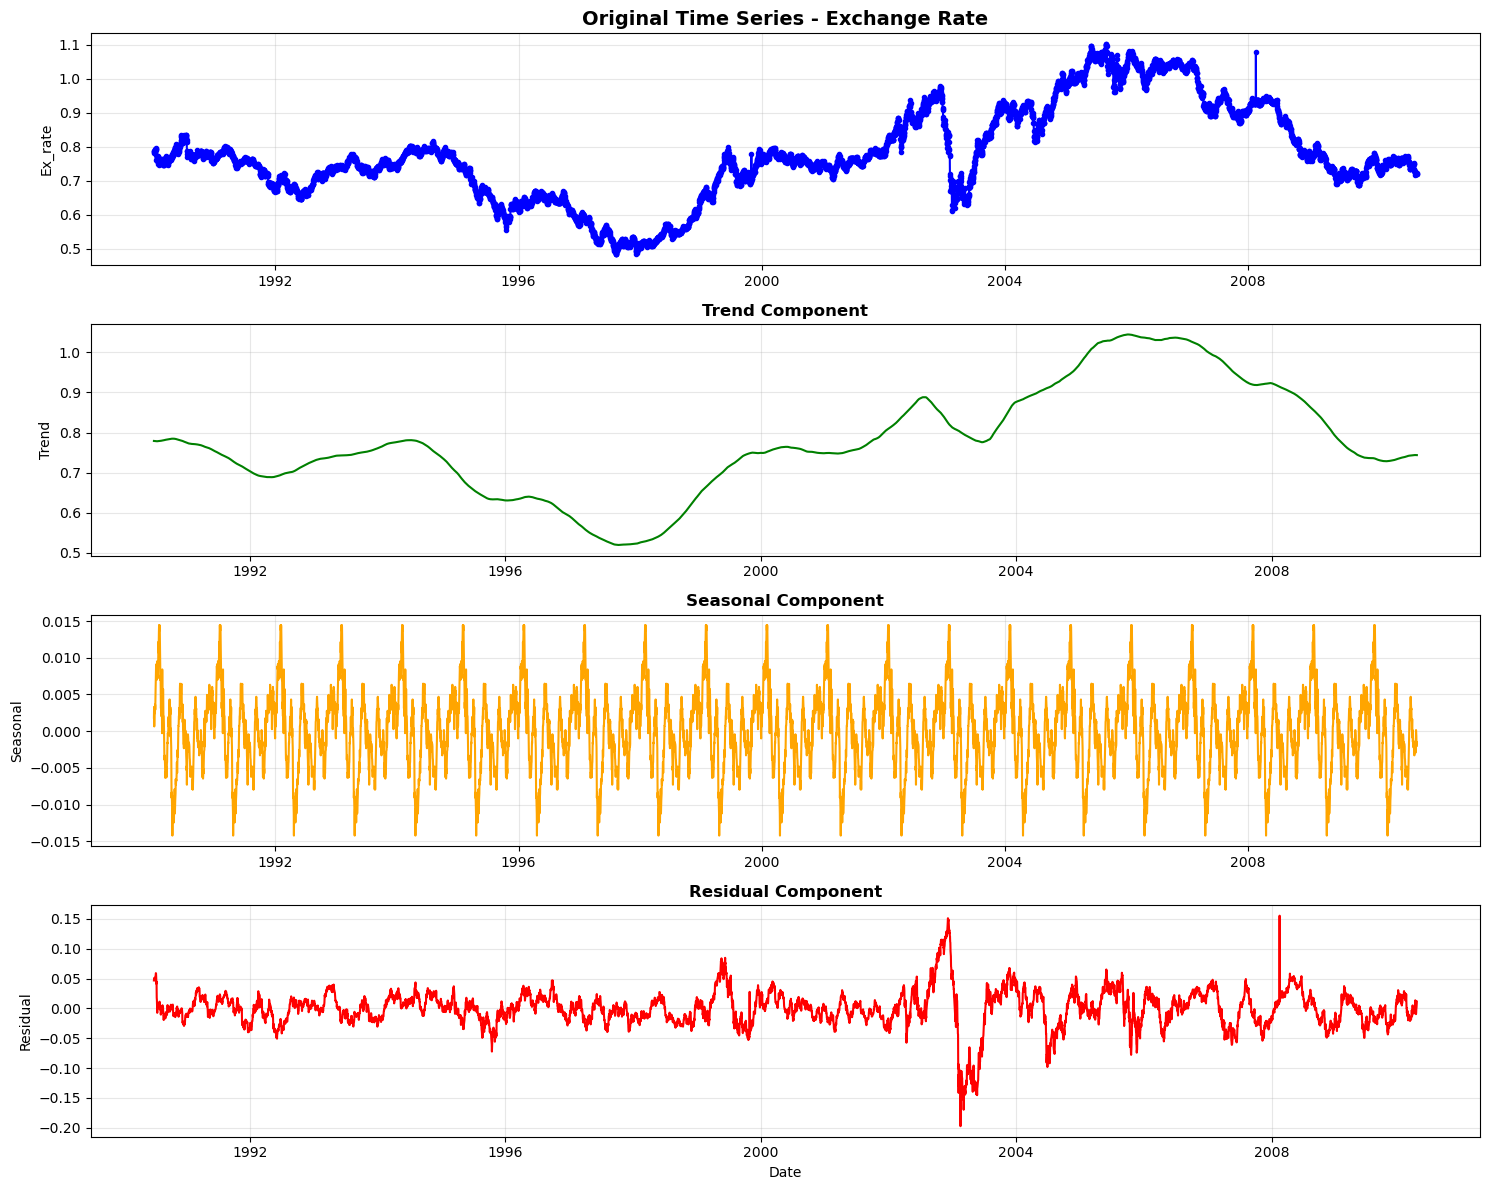

In [16]:

# Plot the time series

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# TIME SERIES DECOMPOSITION

decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=365)  
# 365 → daily seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# ORIGINAL SERIES
axes[0].plot(df.index, df['Ex_rate'], color='blue', linewidth=1.5, marker='.')
axes[0].set_title("Original Time Series - Exchange Rate", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Ex_rate")
axes[0].grid(True, alpha=0.3)

# TREND
axes[1].plot(decomposition.trend, color='green', linewidth=1.5)
axes[1].set_title("Trend Component", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Trend")
axes[1].grid(True, alpha=0.3)

# SEASONAL
axes[2].plot(decomposition.seasonal, color='orange', linewidth=1.5)
axes[2].set_title("Seasonal Component", fontsize=12, fontweight='bold')
axes[2].set_ylabel("Seasonal")
axes[2].grid(True, alpha=0.3)

# RESIDUAL
axes[3].plot(decomposition.resid, color='red', linewidth=1.5)
axes[3].set_title("Residual Component", fontsize=12, fontweight='bold')
axes[3].set_ylabel("Residual")
axes[3].grid(True, alpha=0.3)
axes[3].set_xlabel("Date")

plt.tight_layout()
plt.show()
plt.close()

Missing Values:
 Ex_rate    0
dtype: int64


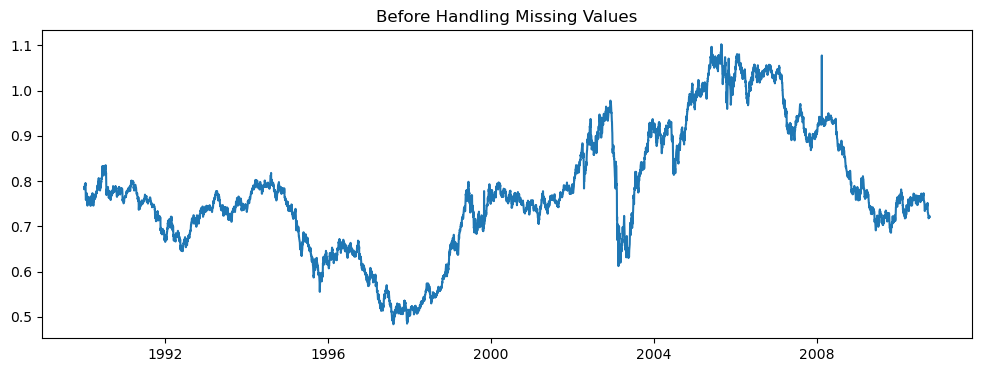

In [17]:
#3.	Data Preprocessing
from scipy import stats

print("Missing Values:\n", df.isnull().sum())

# Plot missing values visually (optional)
plt.figure(figsize=(12, 4))
plt.plot(df['Ex_rate'], label='Original Ex_rate')
plt.title("Before Handling Missing Values")
plt.show()



In [20]:
#  Detect anomalies using Z-score
import numpy as np
z_scores = np.abs(stats.zscore(df['Ex_rate']))
threshold = 3  # common threshold
anomalies = df[z_scores > threshold]
print("\nDetected Anomalies (Z-score > 3):")
print(anomalies)

# # No anomalies were found → dataset is clean


Detected Anomalies (Z-score > 3):
Empty DataFrame
Columns: [Ex_rate]
Index: []


# Part 2: Model Building - ARIMA

In [23]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import itertools
import seaborn as sns
sns.set_style("whitegrid")

# 1) PARAMETER SELECTION: ADF, ACF, PACF

series = df['Ex_rate'].astype(float)

def adf_test(series, title=''):
    print(f"\n>>> ADF Test: {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = dict(zip(labels, result[0:4]))
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    for k, v in out.items():
        print(f"{k}: {v}")
    print("Result: Stationary" if out['p-value'] < 0.05 else "Result: Non-stationary")
    return out

# Test stationarity of original series
adf_orig = adf_test(series, 'Original series')

# If non-stationary, take first difference and test again
d = 0
if adf_orig['p-value'] >= 0.05:
    series_diff1 = series.diff().dropna()
    adf_diff1 = adf_test(series_diff1, '1st difference')
    if adf_diff1['p-value'] < 0.05:
        d = 1
    else:
        # try second diff if necessary (rare)
        series_diff2 = series_diff1.diff().dropna()
        adf_diff2 = adf_test(series_diff2, '2nd difference')
        if adf_diff2['p-value'] < 0.05:
            d = 2

print(f"\nSuggested d (differencing order) = {d}")



>>> ADF Test: Original series
ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974
# Lags Used: 1
# Observations Used: 7586
Critical Value (1%): -3.4312123140180137
Critical Value (5%): -2.861921078147796
Critical Value (10%): -2.5669728434336108
Result: Non-stationary

>>> ADF Test: 1st difference
ADF Statistic: -99.39343120118627
p-value: 0.0
# Lags Used: 0
# Observations Used: 7586
Critical Value (1%): -3.4312123140180137
Critical Value (5%): -2.861921078147796
Critical Value (10%): -2.5669728434336108
Result: Stationary

Suggested d (differencing order) = 1


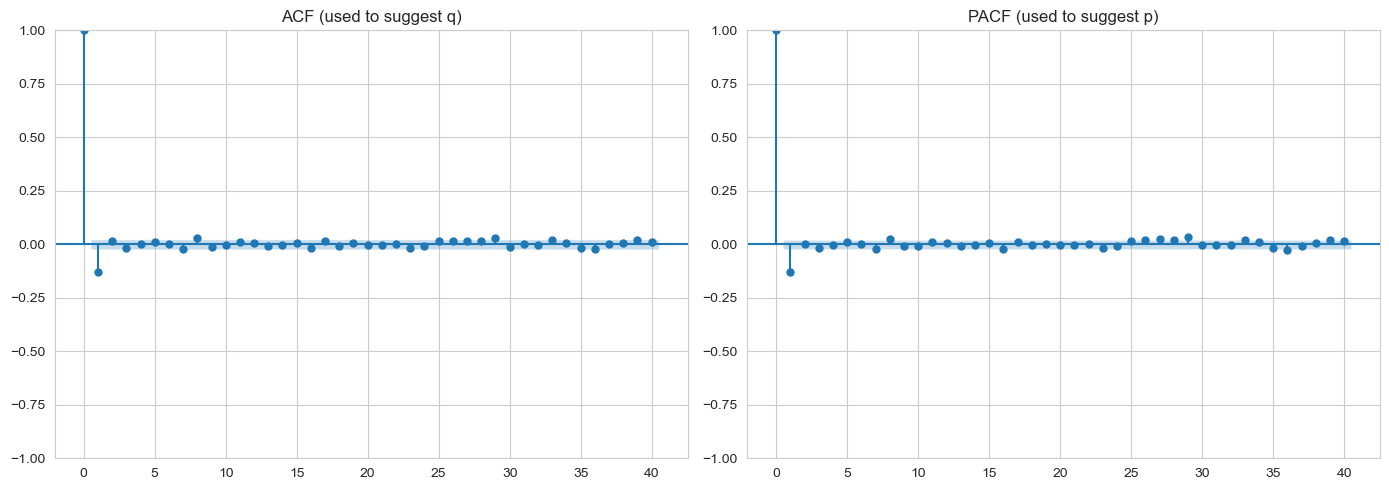

In [24]:
# Plot ACF and PACF to estimate p and q
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
plot_acf(series.dropna().diff(d).dropna() if d>0 else series, lags=40, ax=ax1)
ax1.set_title('ACF (used to suggest q)')
ax2 = plt.subplot(1,2,2)
plot_pacf(series.dropna().diff(d).dropna() if d>0 else series, lags=40, ax=ax2, method='ywm')
ax2.set_title('PACF (used to suggest p)')
plt.tight_layout()
plt.show()

In [25]:
p_range = range(0, 4)
d_range = [d]
q_range = range(0, 4)

In [30]:
# 2) MODEL FITTING: Grid search for best (p,d,q) by AIC
print("\nStarting grid search for ARIMA(p,d,q) by AIC...")

best_aic = np.inf
best_order = None
best_model = None
results = []

total = len(p_range) * len(d_range) * len(q_range)
print(f"Testing {total} combinations...\n")

for p, dd, q in itertools.product(p_range, d_range, q_range):
    try:
        model = ARIMA(series, order=(p, dd, q))
        fitted = model.fit()
        aic = fitted.aic
        results.append({'order': (p, dd, q), 'aic': aic})
        print(f"ARIMA{(p, dd, q)} - AIC: {aic:.2f}")
        if aic < best_aic:
            best_aic = aic
            best_order = (p, dd, q)
            best_model = fitted
    except Exception as e:
        # skip if model fails
        # print(f"ARIMA{(p, dd, q)} failed: {e}")
        continue

print(f"\nBEST model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")

# If grid-search found nothing, recommend fallback (1,d,1)
if best_model is None:
    print("Grid search failed to fit any model. Falling back to ARIMA(1,d,1).")
    best_order = (1, d, 1)
    best_model = ARIMA(series, order=best_order).fit()


Starting grid search for ARIMA(p,d,q) by AIC...
Testing 16 combinations...

ARIMA(0, 1, 0) - AIC: -55974.20
ARIMA(0, 1, 1) - AIC: -56102.75
ARIMA(0, 1, 2) - AIC: -56101.86
ARIMA(0, 1, 3) - AIC: -56102.28
ARIMA(1, 1, 0) - AIC: -56104.32
ARIMA(1, 1, 1) - AIC: -56102.32
ARIMA(1, 1, 2) - AIC: -56101.59
ARIMA(1, 1, 3) - AIC: -56100.39
ARIMA(2, 1, 0) - AIC: -56102.32
ARIMA(2, 1, 1) - AIC: -56100.32
ARIMA(2, 1, 2) - AIC: -56100.14
ARIMA(2, 1, 3) - AIC: -56105.16
ARIMA(3, 1, 0) - AIC: -56102.40
ARIMA(3, 1, 1) - AIC: -56100.40
ARIMA(3, 1, 2) - AIC: -56099.02
ARIMA(3, 1, 3) - AIC: -56090.65

BEST model by AIC: ARIMA(2, 1, 3) with AIC=-56105.16


In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Our time series
series = df['Ex_rate']

# Fit the best ARIMA model
best_model = ARIMA(series, order=(2, 1, 3))
best_result = best_model.fit()

# Model summary
print(best_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 1, 3)   Log Likelihood               28058.578
Date:                Sat, 22 Nov 2025   AIC                         -56105.155
Time:                        12:43:28   BIC                         -56063.550
Sample:                    01-01-1990   HQIC                        -56090.877
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6385      0.144     -4.427      0.000      -0.921      -0.356
ar.L2         -0.7643      0.137     -5.566      0.000      -1.033      -0.495
ma.L1          0.5071      0.144      3.516      0.0

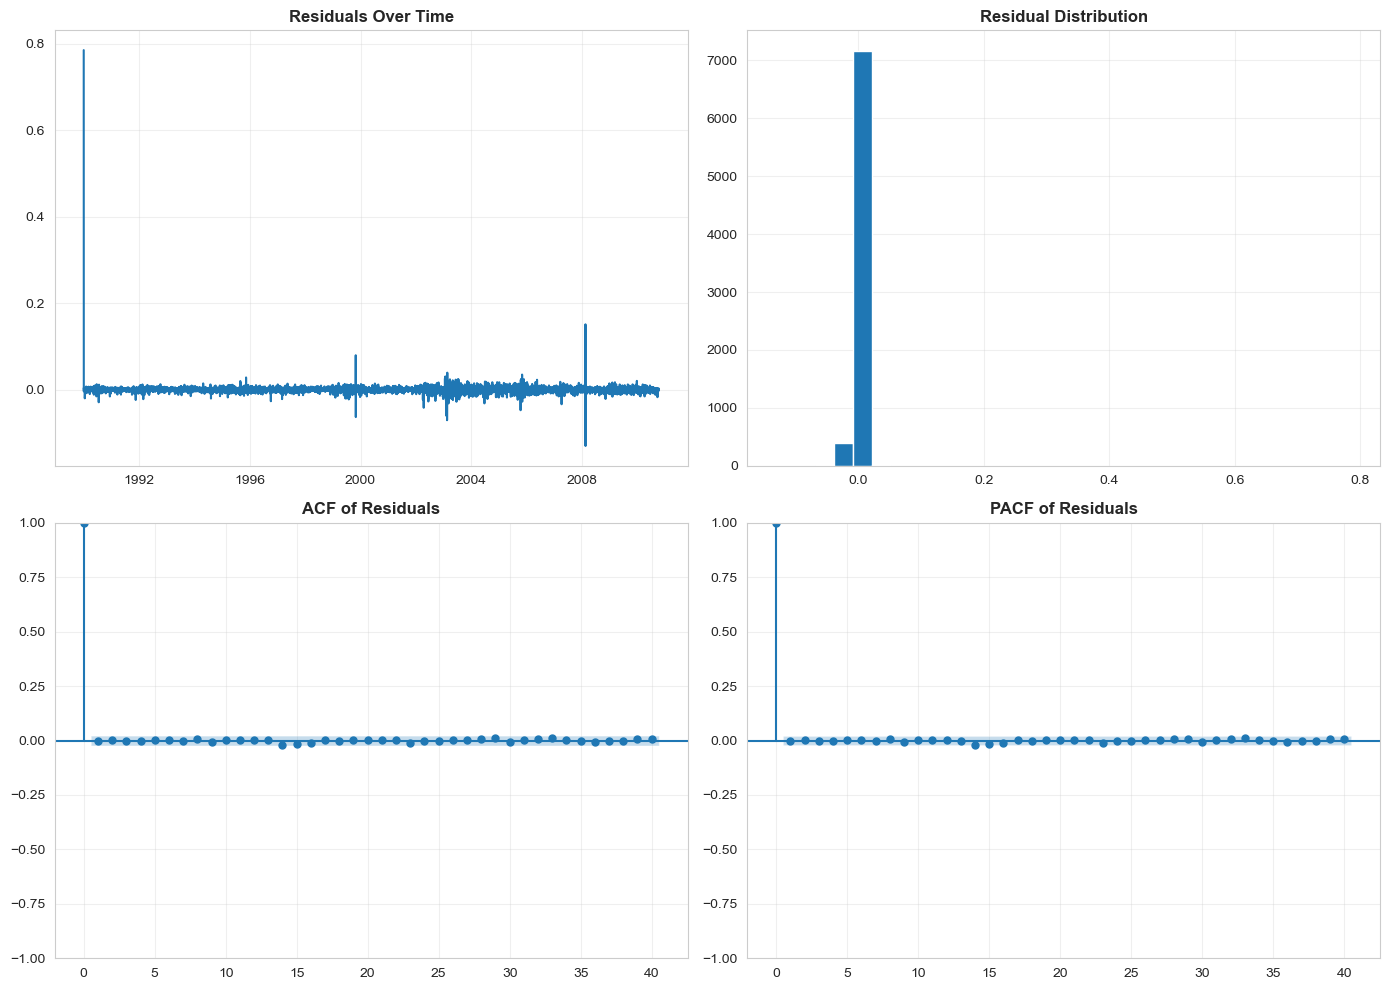

In [31]:
#3.	Diagnostics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuals from the ARIMA(2,1,3) model
residuals = best_result.resid

# Create 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals Over Time", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30)
axes[0, 1].set_title("Residual Distribution", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)

# 3. ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Residuals", fontsize=12, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3)

# 4. PACF of residuals
plot_pacf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title("PACF of Residuals", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

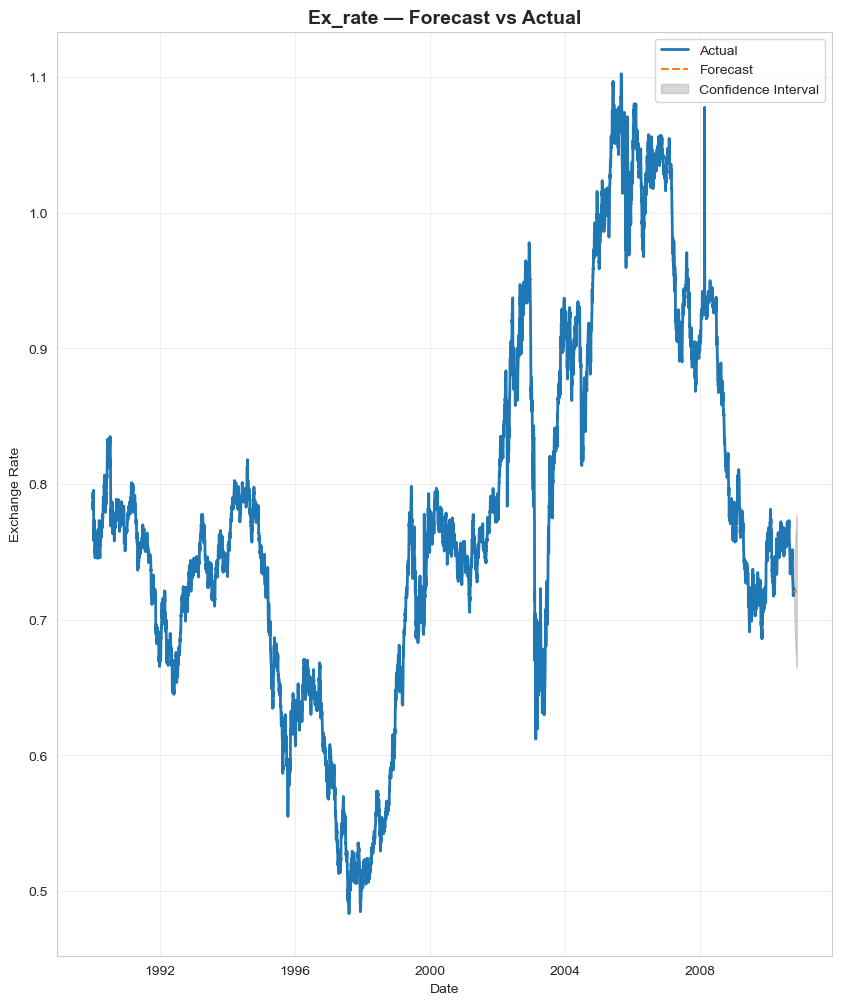

In [36]:
# Forecast horizon (number of days)
forecast_steps = 30

# Generate forecast
forecast_result = best_result.get_forecast(steps=forecast_steps)

# Extract mean forecast and confidence intervals
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Create the plot
plt.figure(figsize=(10, 12))

# Historical data
plt.plot(series, label='Actual', linewidth=2)

# Forecasted values
plt.plot(forecast_mean, label='Forecast', linestyle='--')

# Upper & lower confidence intervals
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='gray',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title('Ex_rate — Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

# Part 3: Evaluation and Comparison

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#1.	Compute Error Metrics

# 1. TRAIN–TEST SPLIT

test_size = 30  # last 30 days for testing

train = df['Ex_rate'][:-test_size]
test = df['Ex_rate'][-test_size:]


# 2. FIT MODEL ON TRAIN DATA


model = ARIMA(train, order=(2, 1, 3))
fitted = model.fit()


# 3. FORECAST EXACT TEST PERIOD

forecast_result = fitted.get_forecast(steps=test_size)
forecast_values = forecast_result.predicted_mean


# 4. COMPUTE METRICS

mae = mean_absolute_error(test, forecast_values)
rmse = np.sqrt(mean_squared_error(test, forecast_values))
mape = np.mean(np.abs((test - forecast_values) / test)) * 100

print("Evaluation Metrics for ARIMA(2,1,3):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

Evaluation Metrics for ARIMA(2,1,3):
MAE  : 0.0135
RMSE : 0.0167
MAPE : 1.86%


1. MAE (Mean Absolute Error) – 0.0135
This means on average, the ARIMA model’s forecasts deviate from actual values by 0.0135 units. A lower MAE indicates strong predictive accuracy.

2. RMSE (Root Mean Squared Error) – 0.0167
RMSE penalizes larger errors more than MAE.
A value of 0.0167 indicates that large deviations are also well-controlled.
Since RMSE is very close to MAE, it suggests the model is not producing unusually large errors.

3. MAPE (Mean Absolute Percentage Error) – 1.86%
MAPE < 5% is generally considered excellent forecasting performance.
So 1.86% means ARIMA model predicts with very high accuracy, having less than 2% average percentage error.

In [38]:
# ARIMA(2,1,3)
# Performance:
# MAE: 0.0135
# RMSE: 0.0167
# MAPE: 1.86%
# These values show excellent forecasting accuracy (MAPE < 5% = highly accurate model).

#Advantages:
# Learns underlying patterns from historical data
# Handles trend well due to differencing
# Lower forecast errors compared to baseline
# Suitable for short-term forecasting

# Limitations:
# Requires stationarity
# Model selection (p, d, q) takes time
# Sensitive to outliers and sudden changes

